# Optimization Progress

In this notebook, we provide visualizations of the optimization progress.

In [1]:
from typing import List
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use("mpl_stylesheet.mplstyle")

In [3]:
def read_prompts(target_experiment: str, tasks: List[str]):
    results = pd.DataFrame()
    for logging_dir in Path(f"../logs/{target_experiment}").rglob("*.csv"):
        if "best_scores" in str(logging_dir):  # or not any(task in str(logging_dir) for task in tasks)
            continue

        result = pd.read_csv(logging_dir)

        logging_dir = str(logging_dir)

        logging_dir = logging_dir.replace(f"..\\logs\\{target_experiment}\\", "")
        logging_dir = logging_dir.replace(".csv", "")

        task_name, optimizer, meta_llm, evaluation_llm, random_seed = logging_dir.split("_")

        task_name = task_name.split("/")[-1].split("\\")[-1]

        metainformation = pd.DataFrame(
            {
                "task": [task_name] * len(result),
                "optimizer": [optimizer] * len(result),
                "meta_llm": [meta_llm] * len(result),
                "evaluation_llm": [evaluation_llm] * len(result),
                "random_seed": [random_seed] * len(result),
            }
        )

        result = pd.concat([result, metainformation], axis=1)

        results = pd.concat([result, results], axis=0)

    return results

In [4]:
def get_first_occurences(df):
    occured = []
    dss = []

    for i in range(1, df["step"].max() + 1):
        df_new = df.loc[(df["step"] == i) & (~df["prompt"].isin(occured))]
        dss.append(df_new)
        occured += df_new["prompt"].to_list()

    return pd.concat(dss)


def get_plot(df1, df2=None, mean_or_max="mean", task=None, optimizer=None, legend_labels=None):
    df = get_first_occurences(df1).copy()
    df = df[(df["task"] == task) & (df["optimizer"] == optimizer)]

    df_ = df.groupby("step", as_index=False).agg(mean_or_max, numeric_only=True)
    df_["score_std"] = df.groupby("step", as_index=False).std(numeric_only=True)["score"]
    df_.loc[df_["score_std"].isna(), "score_std"] = 0
    df = df_.copy()

    # plot average
    plt.plot(
        df["step"],
        df["score"],
        marker="+",
        markersize=8,
        label=legend_labels[0] if legend_labels is not None else None,
        color=sns.color_palette("Set2")[0],
    )
    # Fill the area between std dev lines
    plt.fill_between(
        df["step"],
        df["score"] + df["score_std"],
        df["score"] - df["score_std"],
        alpha=0.2,
        color=sns.color_palette("Set2")[0],
    )

    # plot second line for comparison:
    if df2 is not None:
        df = get_first_occurences(df2).copy()
        df = df[(df["task"] == task) & (df["optimizer"] == optimizer)]

        df_ = df.groupby("step", as_index=False).agg(mean_or_max, numeric_only=True)
        df_["score_std"] = df.groupby("step", as_index=False).std(numeric_only=True)["score"]
        df_.loc[df_["score_std"].isna(), "score_std"] = 0
        df = df_.copy()

        # plot average
        plt.plot(
            df["step"],
            df["score"],
            marker="+",
            markersize=8,
            label=legend_labels[1] if legend_labels is not None else None,
            color=sns.color_palette("Set2")[1],
        )
        # Fill the area between std dev lines
        plt.fill_between(
            df["step"],
            df["score"] + df["score_std"],
            df["score"] - df["score_std"],
            alpha=0.2,
            color=sns.color_palette("Set2")[1],
        )

    # Customize the plot
    plt.title(f"Task {task}, Optimizer {optimizer}")
    plt.xlabel("Step")
    plt.ylabel("Score")
    plt.grid(True)
    plt.legend(loc=2, bbox_to_anchor=(1, 1))

    plt.xticks(np.arange(1, 13))

    plt.ylim(0, 1.1)
    plt.tight_layout()

    return plt.gca()

In [5]:
df = read_prompts(r"../logs\experiment-task-descr", [":)"])
df["use_task_desc"] = True
df2 = read_prompts(r"../logs\experiment", [":)"])
df2["use_task_desc"] = False


df = pd.concat([df, df2])

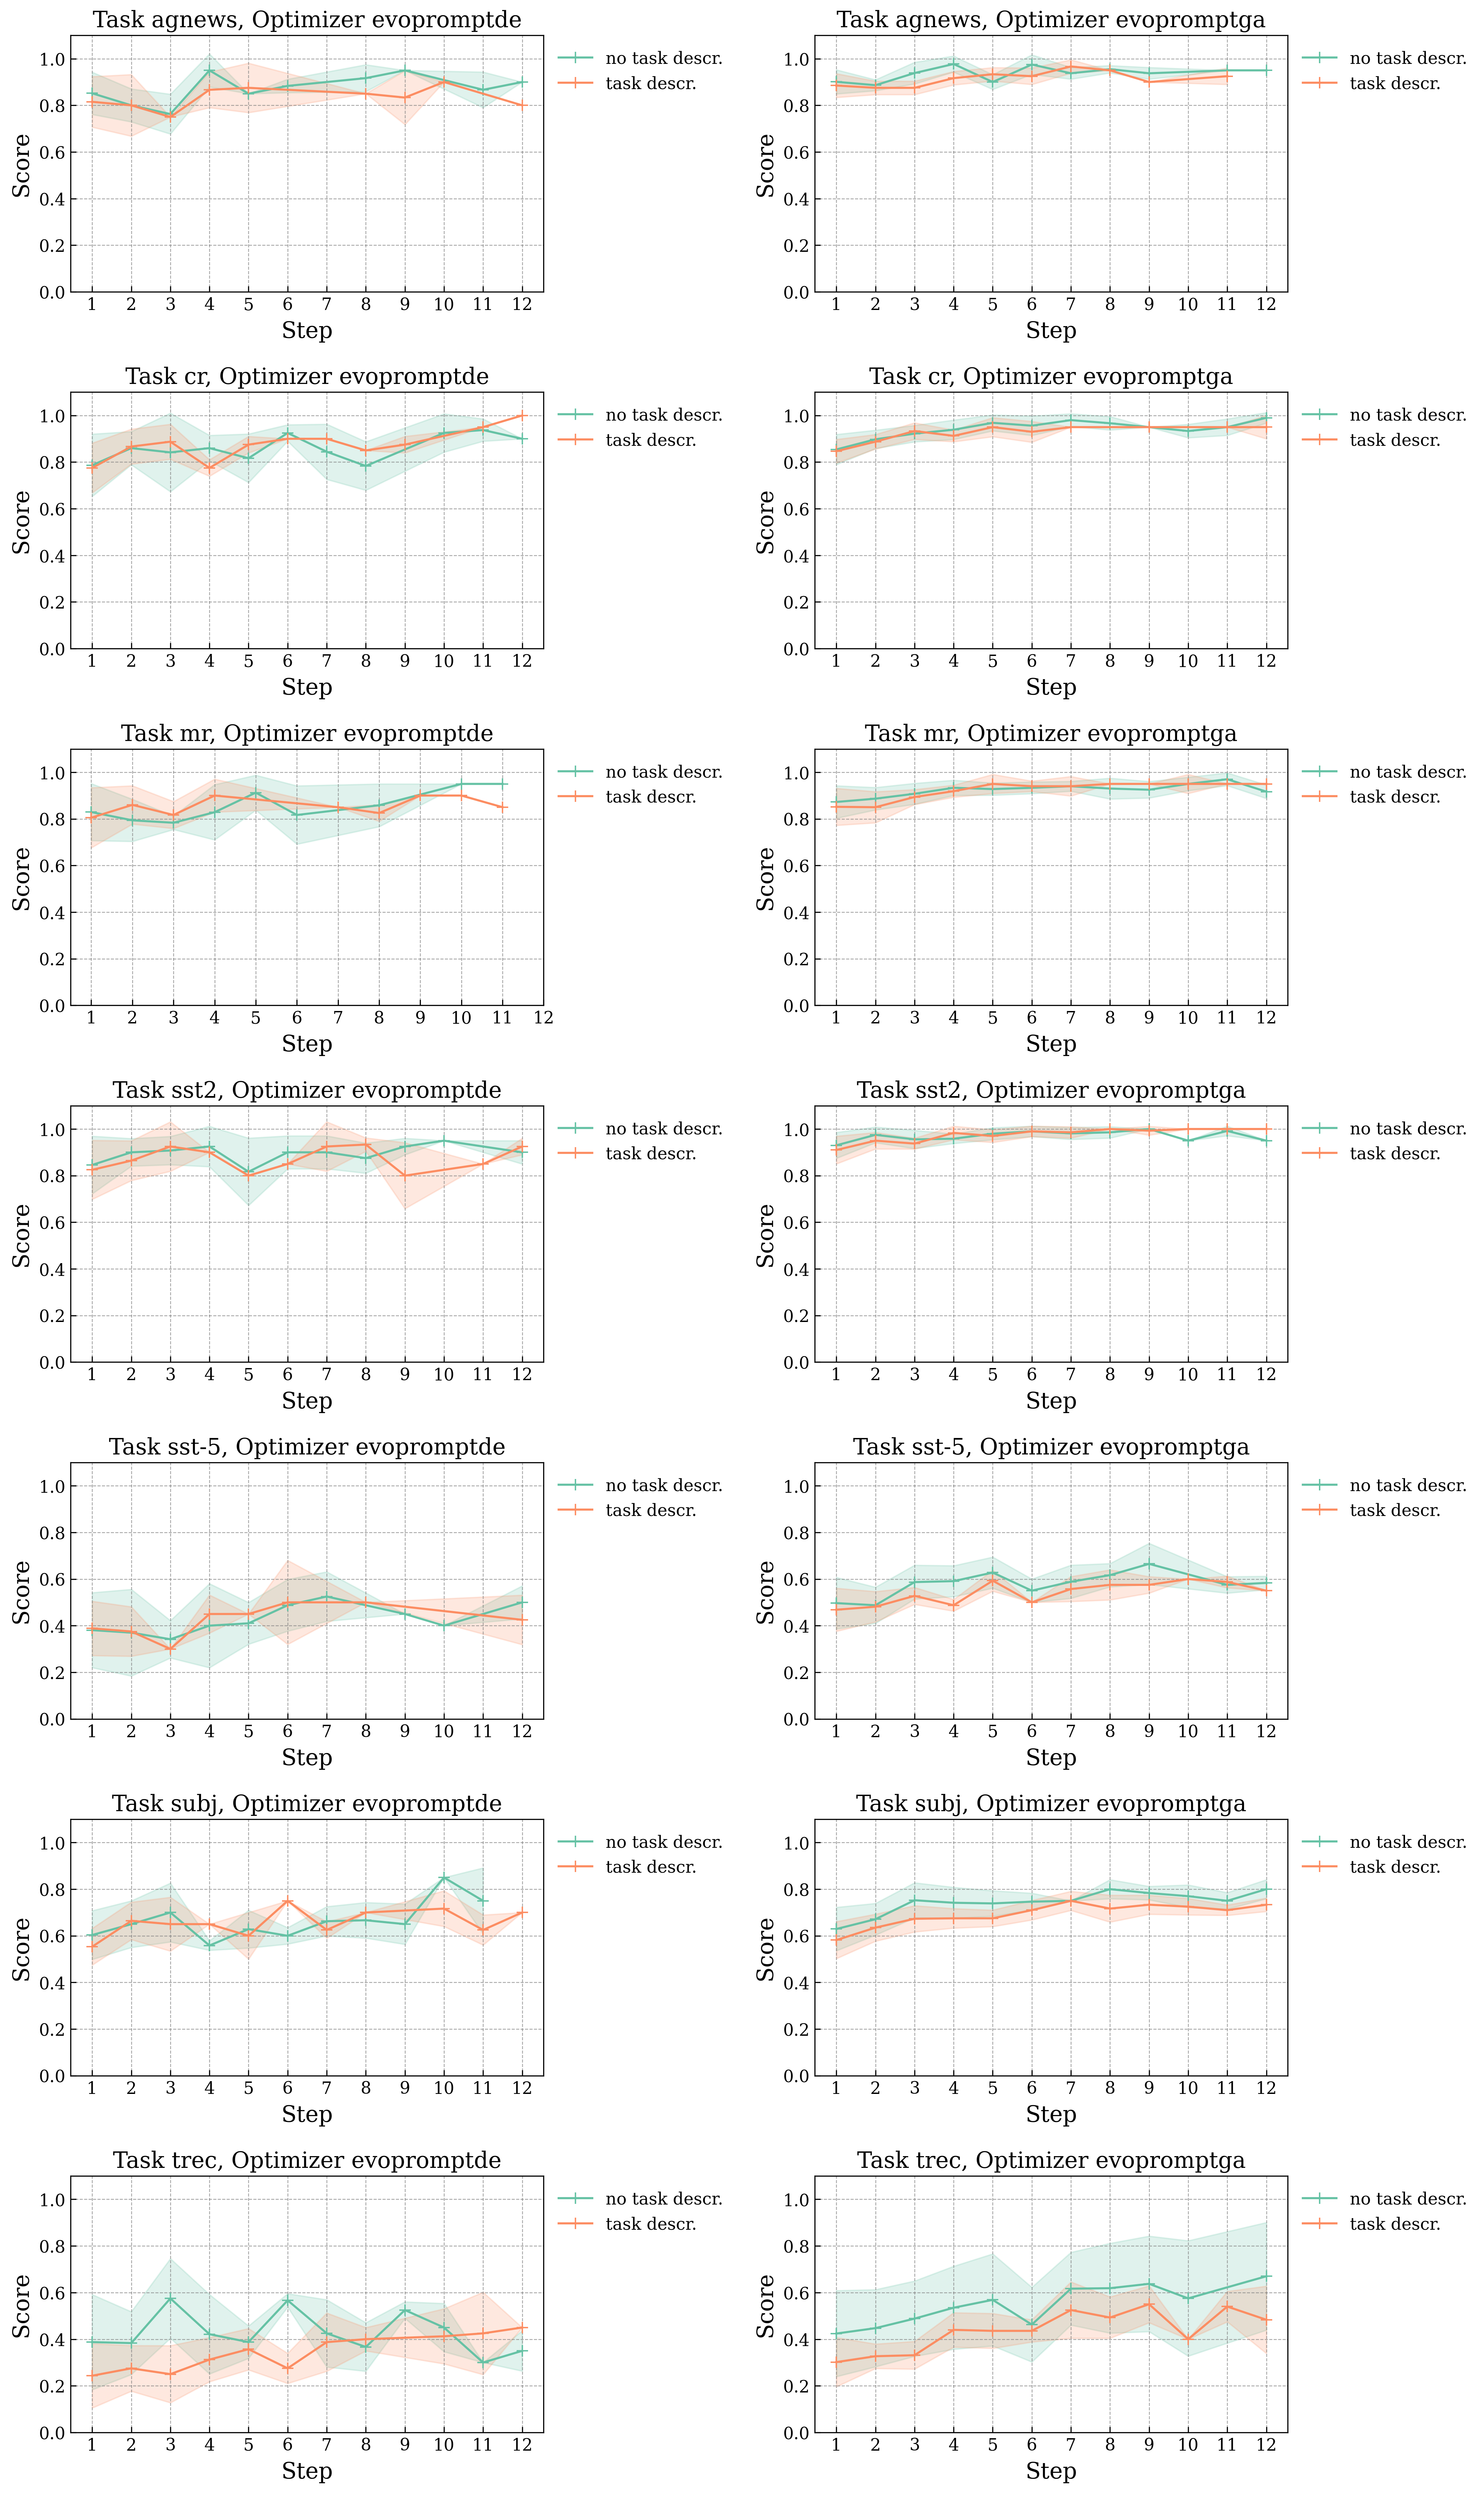

In [6]:
plt.figure(figsize=(15, 25))

for i, task in enumerate(["agnews", "cr", "mr", "sst2", "sst-5", "subj", "trec"]):

    for j, optimizer in enumerate(["evopromptde", "evopromptga"]):
        plt.subplot(7, 2, 2 * i + j + 1)

        get_plot(
            df1=df[~df["use_task_desc"]],
            df2=df[df["use_task_desc"]],
            mean_or_max="mean",
            task=task,
            optimizer=optimizer,
            legend_labels=("no task descr.", "task descr."),
        )
plt.show()